# Strojové učení pod lupou: praktický úvod na příkladu screeningu kognitivních poruch

## *Pracovní notebook pro přednášku na Lékařské fakultě Masarykovy univerzity.*

Ukázka použití a zpracování dat z datsetu **Diadem Speech–Cognitive Dataset (DSCD-CZ)**
http://hdl.handle.net/11234/1-5912

Notebook se věnuje úkolu č.6 - vybavení si co největšího počtu obrázků ze sady 20ti obrázků.
V datasetu je uložena rozpoznaná promluva uživatele a z této promluvy je vytvořen jednoduchý příznakový vektor pro analýzu a klasifikaci dat.


**Autoři notebooku:** Luboš Šmídl, Tomáš Lebeda (Západočeská univerzita v Plzni)  
**Kontakt:** smidl@kky.zcu.cz \
**Datum:** 17. 9. 2025  \
**Verze notebooku:** v1.0


> Tento notebook je licencován pod *Apache License 2.0* © 2025 \
> Můžete používat, upravovat a šířit (i komerčně) s uvedením autora.  

## Stažení a rozbalení dat

1. nejdříve musíme stáhnout data ze serveru LINDAT
2. pak stažený `zip` archiv rozbalíme, abychom měli přímý přístup k datovým souborům

In [ ]:
!curl -o allzip.zip https://lindat.mff.cuni.cz/repository/server/api/core/items/89f117bd-73fe-4371-81e8-faf7a2884b2b/allzip?handleId=11234/1-5912
!unzip -o allzip.zip
!unzip -o DiademSpeechCognitiveDataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  814k    0  814k    0     0   410k      0 --:--:--  0:00:01 --:--:--  410k
Archive:  allzip.zip
  inflating: DiademSpeechCognitiveDataset.md  
  inflating: DiademSpeechCognitiveDataset.zip  
Archive:  DiademSpeechCognitiveDataset.zip
  inflating: ddd.yaml                
  inflating: metadata_20250430.json  
  inflating: recordings_20250430.json  
  inflating: sessions_20250430.json  
  inflating: test_20250430.json      
  inflating: train_20250430.json     
  inflating: transcriptions_annotation_20250430.json  
  inflating: transcriptions_wav2vec_lm-extra04_20250430.json  
  inflating: transcriptions_wav2vec_nolm_20250430.json  
  inflating: transcriptions_zipformer_20250430.json  


## Instalace potřebných Python balíků

Pro zjednodušení práce můžeme použít již existující balíky, které obsahují připravené "stavební bloky".
Typicky se jedná o funkce pro výpočty, načítání a správu dat, nebo vizualizace.

Většina z těchto balíků bývá před-instalována, ale pro jistotu je dáme stáhovat všechny znovu "ručně".
Balíky, které už jsou nainstalované, budou automaticky přeskočené (nebudou stahovány dvakrát).

In [ ]:
!pip install pandas
!pip install pyyaml
!pip install scipy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

## Načtení a zpracování dat

Stažené datové soubory je potřeba načíst a převést do formátu, který bude vhodný pro další výpočty a analýzu.

V kódu jsou postupně provedné kroky:
1. import balíků a funkcí, příprava pomocných proměnných
2. načtení dat ze stažených souborů a uložení do strukturované tabulku (tzv. dataframe)
3. definice pomocných funkcí pro před-zpracování dat (unifikace textů)
4. přejmenování některých sloupců pro lepší přehlednost
5. odstranění nepotřebných informací a doplnění naopak potřebných chybějících
6. zobrazení části dataframu (ukázka, jak vlastně data vypadají)

In [ ]:
import pandas as pd
import numpy as np
import yaml
import json
import string
import re
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from random import random

# list správných 20 obrázků
list_of_20_imgs = [ "ježek", "kalhoty", "velbloud", "ucho", "želva", "ponožka",
                    "lev", "česnek", "klokan",  "ananas", "hroch", "kukuřice",
                    "netopýr", "kaktus", "labuť", "pila", "zebra", "košile",
                    "slepice", "strom" ]

# nastavit zobrazování na 3 desetinná místa
pd.set_option("display.precision", 3)

# načíst datové soubory
with open("sessions_20250430.json", "r") as f:
    id_map = json.load(f)
with open("recordings_20250430.json", "r") as f:
    recordings = json.load(f)
with open("transcriptions_wav2vec_lm-extra04_20250430.json", "r") as f:
    transcriptions = json.load(f)
with open("train_20250430.json", "r") as f:
    train_ids = json.load(f)
with open("test_20250430.json", "r") as f:
    test_ids = json.load(f)


# pomocná funkce pro unifikaci textu
def purify(s):
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r"\s+", " ", s)
    return s

# pomocná funkce pro získání přepisů k vybavení obrázků
def get_texts_20_imgs(scr_id):
    session_ids = [it["session_id"] for it in id_map if it["screening_id"] == scr_id]
    recording_ids = [
        it["recording_id"]
        for it in recordings
        if it["session_id"] in session_ids and it["task"] == "vzpomenutí si na dvacet obrázků"
    ]
    texts = " ".join([purify(it["recognized"]) for it in transcriptions if it["recording_id"] in recording_ids]).split(" ")
    return texts


# načíst metadata
data = pd.read_json('./metadata_20250430.json').set_index("screening_id")

# přejmenovat sloupce
data.rename(columns={
    "osoba_age": "age",
    "osoba_educationYears": "edu_years",
    "osoba_sex": "sex",
    "rbans_vyhodnoceni_souhrnny_skor": "RBANS_score",
    "POBAV_spravne_vybavene_obrazky": "POBAV_imgs"
}, inplace=True)

# přidat sloupec s rozpoznanými slovy pro vybavení obrázků
data["DDD_imgs_words"] = data.index.map(lambda src_id: get_texts_20_imgs(src_id))
data["DDD_imgs"] = data["DDD_imgs_words"].map(lambda lst: len(set([s for s in lst if s in list_of_20_imgs])))

# přidat sloupec s typem osoby (NOS/PAC)
data["category"] = data["kobar_kategorizace_definitivni"].map(lambda i: 0 if i in [0, 1] else 1 )

# ponechat jen relevantní sloupce
data = data[["age", "sex", "edu_years", "RBANS_score", "POBAV_imgs", "DDD_imgs_words", "DDD_imgs", "category"]]

# zobrazit ukázku dat
display(data.head())

,age,sex,edu_years,RBANS_score,POBAV_imgs,DDD_imgs_words,DDD_imgs,category
screening_id,,,,,,,,
scr-moRUHub3BzkxoFK3NE964b,67,1,19,103,10,"[strom, slepice, košile, labuť, pila, hroch, a...",6,0
scr-BoyhzJuyQd4qvpMprMsWjc,78,0,15,104,7,"[kalhoty, ježek, hroch, klokan, ponožka]",5,0
scr-Fcbr8BHyUBmtiibaTCjNRa,78,1,16,79,2,"[ježek, kalhoty, velbout, boty, to, už, to, by...",2,1
scr-b5JnVXU3K2cjh5wPygWCt8,60,1,12,105,8,"[košile, kalhoty, želva, ježek, slepice, labuť...",9,0
scr-9mspzqvUDTvUN3Z2nWPMwF,53,0,19,102,12,"[ananas, kukuřice, košile, slepice, lev, hroch...",13,0


## Základní statistiky

Po připravení dat je vhodné spočítat základní statistiky, abychom měli lepší představu, co se vlastně v datech nachází.

V kódu jsou postupně provedené kroky:
1. výpočet základních statistik nad numerickými daty (střední hodnoty, rozptyl, kvantily, min, max)
2. analýza rozptylu - dopočtení hodnot `ANOVA_F` a `ANOVA_p`
3. zobrazení získaných statistik v tabulce pro jednotlivé sloupce

Více o analýze rozptylu zde: https://cs.wikipedia.org/wiki/Analýza_rozptylu


In [ ]:
# spočítat statistiky
data_stats = data.describe().transpose() # základní statistiky
data_stats.drop(index="category", inplace=True) # statistiky kategorií nechceme
data_stats.drop(columns="count", inplace=True) # počet itemů je všude stejný

# přidat analýzu rozptylů
anova_results = {}
for col in ["age", "sex", "edu_years", "RBANS_score", "POBAV_imgs", "DDD_imgs"]:
    groups = data['category'].unique()
    group_data = [data[col][data['category'] == g].dropna() for g in groups]
    if len(group_data) > 1 and all(len(g) > 0 for g in group_data):
        fvalue, pvalue = stats.f_oneway(*group_data)
        anova_results[col] = {'ANOVA_F': fvalue, 'ANOVA_p': pvalue}
anova_df = pd.DataFrame.from_dict(anova_results, orient='index')
data_stats = data_stats.merge(anova_df, left_index=True, right_index=True, how='left')

# zobrazit statistiky
display(data_stats)

,mean,std,min,25%,50%,75%,max,ANOVA_F,ANOVA_p
age,66.604,11.237,45.0,56.00,68.0,77.0,89.0,35.416,8.373e-09
sex,0.325,0.469,0.0,0.00,0.0,1.0,1.0,0.225,6.353e-01
edu_years,15.302,3.315,8.0,12.75,15.0,18.0,25.0,19.399,1.539e-05
RBANS_score,98.142,18.162,49.0,87.00,101.0,112.0,149.0,269.844,2.419e-42
POBAV_imgs,7.869,2.798,0.0,6.00,8.0,10.0,15.0,163.350,1.744e-29
DDD_imgs,6.399,3.197,0.0,4.00,7.0,9.0,15.0,121.701,1.501e-23


## Grafické zobrazení dat

Kromě statistik se také často hodí zobrazit data vizuálně, někdy tak lze získat lepší představu o tom, jak jsou data skutečně rozložená.

Kód zobrazuje všechna dostupná data jako body v rovině, kde:
- vodorovná osa odpovídá věku osoby
- svislá osa odpovídá počtu let vzdělání
- barevně jsou odlišené kategorie osob (PAC = pacient, NOS = normální osoba)
- symbolem křížku/kroužku jsou rozlišené pohlaví osob

Z vizualizace lze vidět, že větší množství pacientů je koncentrováno v pravé dolní části, což odpovídá starším osobám s nižším vzděláním.

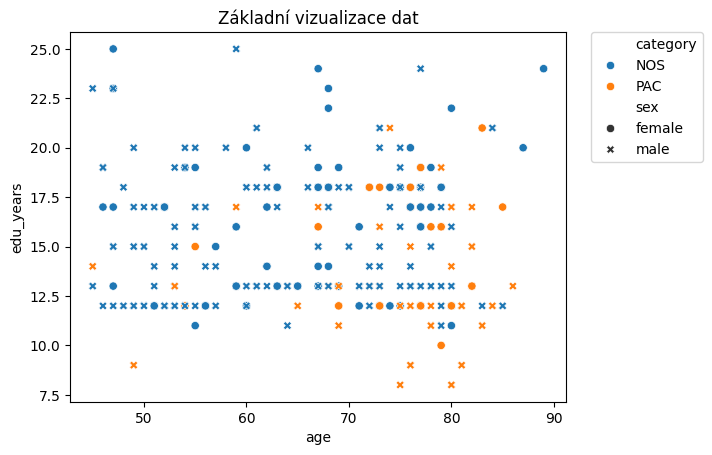

In [ ]:
# grafické zobrazení dat
plot_df = data.copy()
plot_df["sex"] = plot_df['sex'].map({0: 'male', 1: 'female'})
plot_df["category"] = plot_df["category"].map({0: "NOS", 1: "PAC"})
ax = sb.scatterplot(plot_df, x="age", y="edu_years", style="sex", hue="category")
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Základní vizualizace dat")
plt.show()

## Úloha klasifikace

V této části notebooku se zaměříme na **klasifikaci**, což je jedna ze základních úloh v oblasti strojového učení.
Klasifikace slouží k tomu, abychom na základě pozorovaných vlastností (příznaků) dokázali zařadit určitý objekt nebo jev do jedné z předem definovaných skupin neboli tříd.

Představte si to jako třídění pacientů na základě jejich symptomů a výsledků vyšetření do skupin s různými diagnózami.
V našem případě je úloha jednodušší - jedná se o **binární klasifikaci**, což znamená, že máme pouze dvě možné třídy, do kterých můžeme osoby zařadit:

- **PAC** (pacient): Osoba, u které byla diagnostikována sledovaná kognitivní porucha.
- **NOS** (normální zdravá osoba): Osoba, u které nebyla diagnostikována sledovaná kognitivní porucha a slouží jako kontrolní skupina.

Cílem klasifikace je vytvořit systém (klasifikátor), který dokáže pro novou, dosud neviděnou osobu co nejpřesněji odhadnout, zda patří do kategorie PAC nebo NOS.
Klasifikátor se "učí" z dat, která již máme k dispozici a u kterých známe správnou kategorii (trénovací data).

V kontextu medicíny může být takový klasifikační model užitečným nástrojem pro podporu rozhodování lékaře při diagnostice, screeningu nebo stratifikaci rizika pacientů.

### ROC křivky pro jednotlivé příznaky

Pro vybrané příznaky jsou vukreslené ROC křivky:
 - ROC (Receiver Operating Characteristic) křivka ukazuje vztah mezi **citlivostí** a **1-specificitou** pro různé prahové hodnoty.  
  - Umožňuje posoudit **schopnost modelu odlišit dvě třídy** nezávisle na zvoleném prahu.  
  - AUC (Area Under Curve) kvantifikuje kvalitu modelu - čím vyšší AUC, tím lepší separace tříd.

V kódu je postupně pro jednotlivé příznaky spočtená křivka a vykreslena do společného grafu.

Ze získaného grafu je možné vidět, že různé příznaky (samy o sobě) dokáží různě dobře odlišit pacienty od zdravých osob.
Příznaky založené na obrázcích fungují lépe než věk a nejslabší je počet let vzdělání.

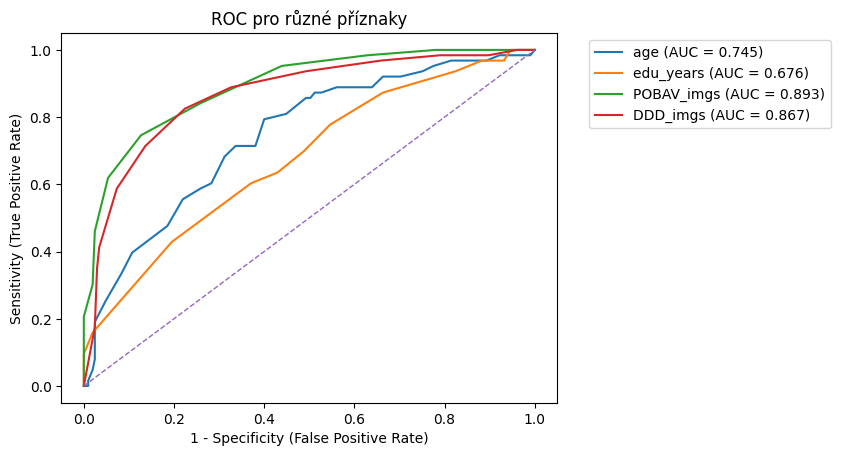

In [ ]:
# pomocná funkce pro kreslení ROC křivek
def orient_scores_for_roc(y_true_bin, scores):
    """
    Pokud AUC < 0.5, otočí skóre (vynásobí -1), aby ROC byla nad diagonalou.
    Vrací (scores_oriented, auc_oriented).
    """
    if pd.Series(y_true_bin).nunique() < 2 or pd.Series(scores).nunique() < 2:
        return scores, np.nan
    auc_raw = metrics.roc_auc_score(y_true_bin, scores)
    if auc_raw < 0.5:
        scores = -np.asarray(scores, dtype=float)
        auc_fixed = 1 - auc_raw
    else:
        auc_fixed = auc_raw
    return scores, auc_fixed

# výpočet a zobrazení ROC křivek
plt.figure()
for col in ["age", "edu_years", "POBAV_imgs", "DDD_imgs"]:
    y_true = data["category"]
    y_score = data[col]
    y_score_oriented, auc_val = orient_scores_for_roc(y_true, y_score)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_score_oriented)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{col} (AUC = {roc_auc:.3f})")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.title("ROC pro různé příznaky")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.show()

## Vytvoření komplexních příznaků pro klasifikaci

Samostatné numerické příznaky dostupné přímo z dat nemusí být dostačující.
Pro klasifikaci se často tvoří komplexnější příznakové vektory, které v sobě mají zakódováné bohatší informace.

V tomto případě vytvoříme příznakový vektor, který bude obsahovat:
1. informace o tom, zda bylo dané slovo řečeno (hodnota 1), či nikoli (hodnota 0) - bude se tedy jednat o sekvence dvaceti jedniček a nul
2. celkový počet správně vybavených slov (jedno celé číslo)
3. celkový počet všech slov, které člověk řekl (jedno celé číslo)

Celkem tedy pro každou osobu bude mít příznakový vektor 22 hodnot.

V následujícím kódu jsou tyto vektory spočtené pro každý dostupný záznam a  prvních několik je zobrazeno.

Poslední sloupec `category` není součástí příznakového vektoru (později bude oddělen) a obsahuje informace o tom, zda se jedná skutečně o pacienta, či zdravého jedince.

Na konci jsou data rozdělena na dvě množiny: trénovací a testovací, význam bude vysvětlen později.

In [ ]:
# pomocná funkce pro vytvoření dataframu s příznaky
def build_feature_df(data):
    feature_rows = []
    for idx, row in data.iterrows():
        words = row.DDD_imgs_words
        checks = [int(target in words) for target in list_of_20_imgs]
        feature_rows.append({
            "idx": idx,
            **{f"w{i+1}_{target}": val for i, (target, val) in enumerate(zip(list_of_20_imgs, checks))},
            "total_correct": sum(checks),
            "total_words": len(words)
        })
    return pd.DataFrame(feature_rows).set_index("idx")

# sestavení příznaků a targetů
features = build_feature_df(data)
features["category"] = data["category"].values
display(features.head())

# Split into train-test X-y
X_train = features.loc[features.index.isin(train_ids)].drop(columns=["category"])
X_test = features.loc[features.index.isin(test_ids)].drop(columns=["category"])
y_train = features.loc[features.index.isin(train_ids)]["category"]
y_test = features.loc[features.index.isin(test_ids)]["category"]

,w1_ježek,w2_kalhoty,w3_velbloud,w4_ucho,w5_želva,w6_ponožka,w7_lev,w8_česnek,w9_klokan,w10_ananas,...,w14_kaktus,w15_labuť,w16_pila,w17_zebra,w18_košile,w19_slepice,w20_strom,total_correct,total_words,category
idx,,,,,,,,,,,,,,,,,,,,,
scr-moRUHub3BzkxoFK3NE964b,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,6,12,0
scr-BoyhzJuyQd4qvpMprMsWjc,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,5,5,0
scr-Fcbr8BHyUBmtiibaTCjNRa,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,16,1
scr-b5JnVXU3K2cjh5wPygWCt8,1,1,0,1,1,0,0,0,0,0,...,0,1,0,1,1,1,0,9,10,0
scr-9mspzqvUDTvUN3Z2nWPMwF,0,1,0,0,0,1,1,1,1,1,...,0,0,1,1,1,1,0,13,13,0


## Vizualizace četnosti vybavení obrázků

Dalším krokem je zobrazení toho, jak často si které slovo lidé dokáží vybavit.

Jak interpretovat zobrazený graf:
- na svislé ose jsou jednotlivá slova v pořadí, jak byla zobrazena při vyšetření
- velikost sloupce udává relativní četnost vybavení tohoto slova
- pro každé slovo jsou barevně odlišené hodnoty pro pacienty (oranžově) a pro zdravé osoby (modře)

Například:
- na slovo "ježek" si vzpomnělo 78% zdravých osob a 50.8% pacientů
- na slovo "velbloud" si vzpomnělo pouze 44.9% zdravých osob a 20.% pacientů

Z grafu lze sledovat, že různá slova se lidem obecně různě dobře pamatují a že poměry mezi kategoriemi osob jsou také odlišné.

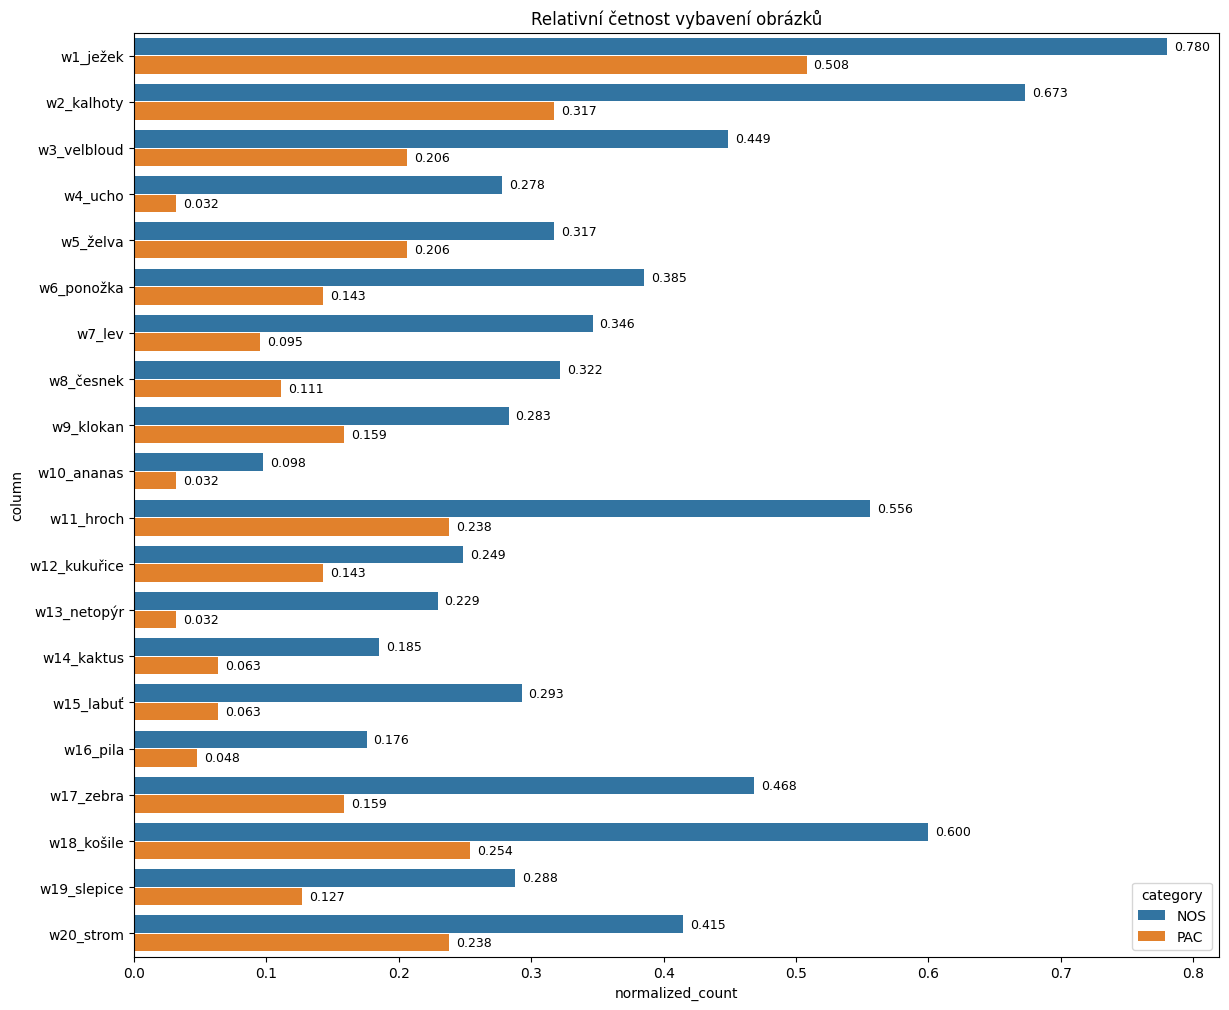

In [ ]:
# vizualizace četnosti vybavení obrázků
cols = [f"w{i+1}_{target}" for i, target in enumerate(list_of_20_imgs)]
grouped = features.groupby("category")[cols]
df = grouped.sum().div(grouped.count(), axis=0).reset_index()
df["category"] = df["category"].map({0: "NOS", 1: "PAC"})

df = df.melt(id_vars = "category", value_vars = cols, var_name="column", value_name="normalized_count")
plt.figure(figsize=(14,12))
ax = sb.barplot(df, y="column", x="normalized_count", hue="category", gap=0.05) # type: ignore
ax.bar_label(ax.containers[0], fontsize=9, padding=5, fmt="%.3f")
ax.bar_label(ax.containers[1], fontsize=9, padding=5, fmt="%.3f")
plt.title("Relativní četnost vybavení obrázků")
plt.show()

## Heat-mapa pořadí vybavení obrázků

Předchozí graf zobrazoval pouze četnost vybavení, bez ohledu na pořadí, v jakém si člověk na obrázek vzpomněl.
Následující vizualizace bere v potaz i pořadí vybavení obrázku.

Jak interpretovat graf:
- svislá osa odpovídá jednotlivým slovům
- vodorovná osa odpovídá pořadí, ve kterém bylo slovo řečeno při vybavení
- barva (a číslo) odpovídá četnosti výskytu

Například:
- slovo "ježek" si lidé vybavili jako první v pořadí celkem 89krát
- slovo "kalhoty" si lidé vybavili jako druhé v pořadí celkem 26krát
- slovo "ananas" nikdo neřekl jako páté v pořadí

Opět lze z vizualizace pozorovat, že různá slova jsou různě obtížná na zapamatování a nejčastěji lidé jako první řeknou "ježek" a "strom", což jsou zároveň první a poslední obrázky, které jsou zobrazené.

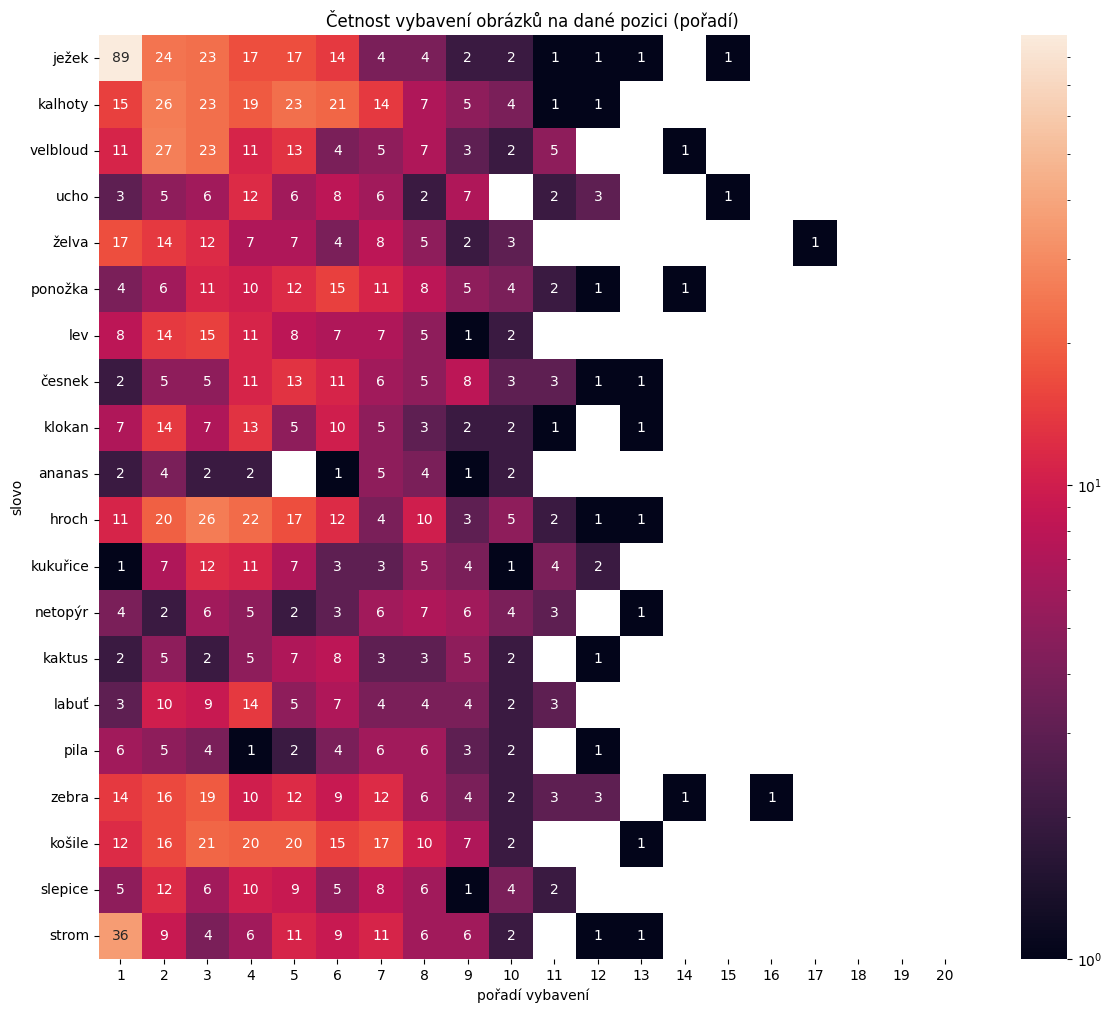

In [ ]:
# heatmapa pořadí vybavení
from matplotlib.colors import LogNorm, Normalize

dct = {w: [0] * 20 for w in list_of_20_imgs}
for i, row in data.iterrows():
    words = [w for w in row.DDD_imgs_words if w in list_of_20_imgs]
    for wi, word in enumerate(words):
        dct[word][wi] += 1
df = pd.DataFrame.from_dict(dct, orient="index")
df.columns = range(1, 21) # type: ignore

plt.figure(figsize=(14,12))
ax = sb.heatmap(df, annot=True, norm=LogNorm())

plt.title("Četnost vybavení obrázků na dané pozici (pořadí)")
plt.xlabel("pořadí vybavení")
plt.ylabel("slovo")
plt.show()

## První klasifikátor

Když máme připravená data, můžeme začít s klasifikací.

1. vytvoříme klasifikátor (můžeme zvolit jeden z mnoha před-připravených typů, v kódu jsou 3 možnosti)
2. natrénujeme klasifikátor na trénovacích datech
3. necháme klasifikátor, aby odhadl kategorii osob (tzv. predikce)
4. porovnáme skutečné kategorie a predikované

Vyhodnocení:
- v první tabulce jsou běžné metriky (precision, recall, f1-score) pro jednotlivé kategorie i pro celkové data
- ve druhé tabulce je zobrazena tzv. konfuzní matice, kde je znázorněno, kolik záznamů bylo přiřazeno do které třídy oproti jejich skutečné kategorii

_Přenost je prakticky 100% a v konfuzní tabulce je pouze 1 špatně zařazená osoba - znamená to, že jsme dokázali vytvořit téměř perfektní klasifikátor?_

Klasifikace - vyhodnocení na trénovacích datech:

              precision    recall  f1-score   support

         NOS       0.99      1.00      1.00       164
         PAC       1.00      0.98      0.99        51

    accuracy                           1.00       215
   macro avg       1.00      0.99      0.99       215
weighted avg       1.00      1.00      1.00       215



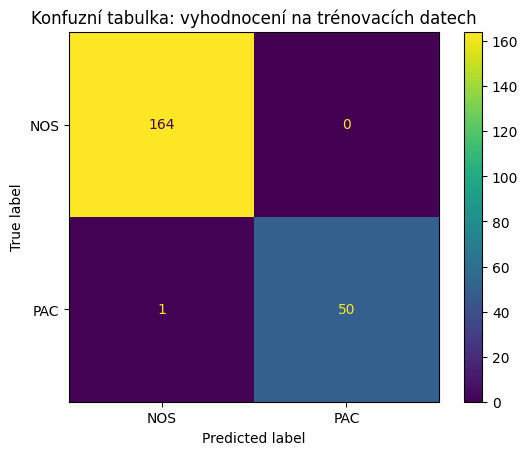

In [ ]:
# výběr klasifikátoru

clf = RandomForestClassifier() # link: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# clf = KNeighborsClassifier() # link: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# clf = LogisticRegression() # link: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf.fit(X_train, y_train)

# predikce a vyhodnocení
predictions = clf.predict(X_train)
report = classification_report(y_train, predictions, target_names=["NOS", "PAC"])
print("Klasifikace - vyhodnocení na trénovacích datech:\n")
print(report)
ConfusionMatrixDisplay.from_predictions(y_train, predictions, display_labels=["NOS", "PAC"])
plt.title("Konfuzní tabulka: vyhodnocení na trénovacích datech")
plt.show()

## Predikce a vyhodnocení na testovacích datech

V předchozím případě jsme dělali vyhodnocení na trénovacích datech - tj. na stejných datech, na kterých byl klasifikátor trénován.

To je chyba, protože na trénovacích datech budou výsledky prakticky vždy vynikajicí.
Je to podobné, jako kdyby student dopředu znal přesné otázky v testu a tak se naučil jen přesně tyto otázky - výsledek testu bude mít vynikajicí, ale jeho skutečné znalosti budou výrazně slabší.

Proto zde provedeme krok predikce a vyhodnocení na testovacích datech - to jsou data, která klasifikátor doposud neviděl, jsou pro něj nová.

Na obou výstupních metrikách je možné vidět výrazný pokles úspěšnosti a větší počet chyb - očekávaně.

_Můžeme klasifikaci ještě dále zlepšit?_

Klasifikace - vyhodnocení na testovacích datech

              precision    recall  f1-score   support

         NOS       0.90      0.88      0.89        41
         PAC       0.62      0.67      0.64        12

    accuracy                           0.83        53
   macro avg       0.76      0.77      0.76        53
weighted avg       0.84      0.83      0.83        53



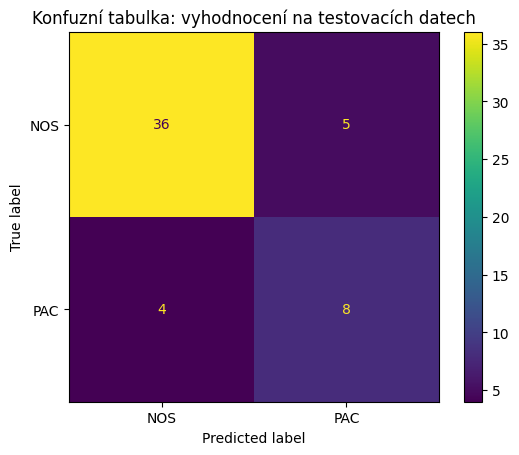

In [ ]:
# predikce a vyhodnocení na testovacích datech
predictions = clf.predict(X_test)
report = classification_report(y_test, predictions, target_names=["NOS", "PAC"])
print("Klasifikace - vyhodnocení na testovacích datech\n")
print(report)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=["NOS", "PAC"])
plt.title("Konfuzní tabulka: vyhodnocení na testovacích datech")
plt.show()

## ROC křivka pro natrénovaný klasifikátor

Pro natrénovaný klasifikátor lze také sestavit ROC křivka.
Rozdíl oproti předchozí ROC charakteristice je v použití klasifikátoru a samotném příznakovém vektoru.

Na grafu je kromě samotné křivky zobrazeno také několik bodů s popisky, které předstravují klasifikační hranici (threshold).
Změnou tohoto thresholdu je možné "cestovat" po křivce a měnit tak poměr mezi senzitivitou a 1-specificitou (podle toho, jestli je lepší mít více "zapomenutých detekcí" nebo "falešných poplachů").

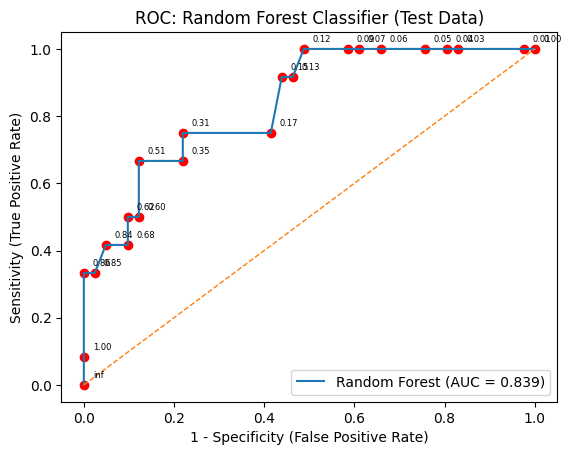

In [ ]:
# ROC pro klasifikátor trénovaný na train datech
y_score_clf = clf.predict_proba(X_test)[:, 1] # type: ignore
fpr_clf, tpr_clf, thresholds = roc_curve(y_test, y_score_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)

plt.figure()
plt.plot(fpr_clf, tpr_clf, label=f"Random Forest (AUC = {roc_auc_clf:.3f})")
plt.scatter(fpr_clf, tpr_clf, color="red")
for x, y, val in zip(fpr_clf, tpr_clf, thresholds):
    plt.text(x + 0.02, y + 0.02, f"{val:0.2f}", fontsize=6)

plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.title("ROC: Random Forest Classifier (Test Data)")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.legend(loc="lower right")
plt.show()

## Rozšíření příznakového vektoru

Jedním ze způsobů, jak je možné zlepšit klasifikace, je přidat informace do příznakového vektoru.
V tomto případě máme k dispozici ještě informace o věku a vzdělání osoby, která doposud nebyla použita.

V kódu jsou relevantní sloupce přidané do současných dat a opět je několik prvních záznamů zobrazeno

In [ ]:
# přidání sociodemografických příznaků do příznakového vektoru
X_train["age"] = data.loc[data.index.isin(train_ids)]["age"]
X_train["edu_years"] = data.loc[data.index.isin(train_ids)]["edu_years"]
#X_train["sex"] = data.loc[data.index.isin(train_ids)]["sex"]
X_test["age"] = data.loc[data.index.isin(test_ids)]["age"]
X_test["edu_years"] = data.loc[data.index.isin(test_ids)]["edu_years"]
#X_test["sex"] = data.loc[data.index.isin(test_ids)]["sex"]

display(X_train.head())
# display(X_test.head())

,w1_ježek,w2_kalhoty,w3_velbloud,w4_ucho,w5_želva,w6_ponožka,w7_lev,w8_česnek,w9_klokan,w10_ananas,...,w15_labuť,w16_pila,w17_zebra,w18_košile,w19_slepice,w20_strom,total_correct,total_words,age,edu_years
idx,,,,,,,,,,,,,,,,,,,,,
scr-moRUHub3BzkxoFK3NE964b,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,6,12,67,19
scr-BoyhzJuyQd4qvpMprMsWjc,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,5,5,78,15
scr-b5JnVXU3K2cjh5wPygWCt8,1,1,0,1,1,0,0,0,0,0,...,1,0,1,1,1,0,9,10,60,12
scr-9mspzqvUDTvUN3Z2nWPMwF,0,1,0,0,0,1,1,1,1,1,...,0,1,1,1,1,0,13,13,53,19
scr-BDtcMxgdLoun6pCeE7PSK8,0,0,0,1,1,0,0,0,0,0,...,1,1,0,0,0,0,4,8,77,18


## Klasifikátor s rozšířeným příznakovým vektorem

Model natrénujeme na trénovacích datech s rozšířeným příznakovým vektorem.

Následně rovnou uděláme vyhodnocení na testovacích datech, stejně jako v předchozích krocích.

Na výsledcích i konfuzní tabulce je možné vidět, že rozšíření příznakového vektoru o věk a vzdělání znatelně přispělo k lepší úspěšnosti klasifikace a redukci počtu chyb.

Klasifikace - vyhodnocení na testovacích datech (včetně SD):

              precision    recall  f1-score   support

         NOS       0.97      0.85      0.91        41
         PAC       0.65      0.92      0.76        12

    accuracy                           0.87        53
   macro avg       0.81      0.89      0.83        53
weighted avg       0.90      0.87      0.88        53



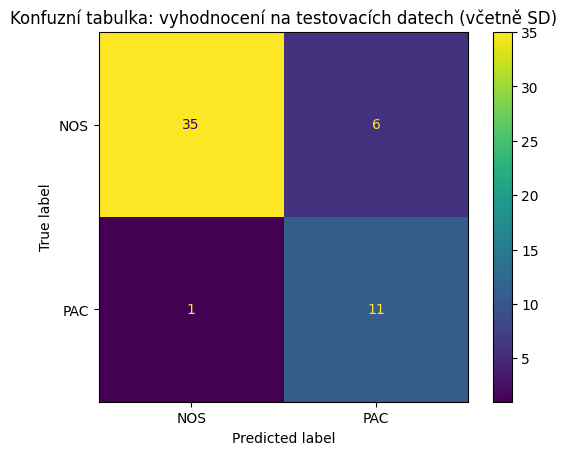

In [ ]:
# znovu a natrénování klasifikátoru (včetně SD příznaků)
clf.fit(X_train, y_train)

# predikce a vyhodnocení na testovacích datech (včetně SD příznaků)
predictions = clf.predict(X_test)
report = classification_report(y_test, predictions, target_names=["NOS", "PAC"])
print("Klasifikace - vyhodnocení na testovacích datech (včetně SD):\n")
print(report)
ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=["NOS", "PAC"])
plt.title("Konfuzní tabulka: vyhodnocení na testovacích datech (včetně SD)")
plt.show()

## ROC křivka pro klasifikaci s rozšířenými příznaky

Opět sestavíme ROC křivku pro výsledky klasifikátoru a zobrazíme body s threshold hodnotami.

V porovnání s předchozí ROC křivkou je znatelné, že schopnost rozlišit mezi pacienty a normálními osobami vzrostla po rozšíření příznakového vektoru.

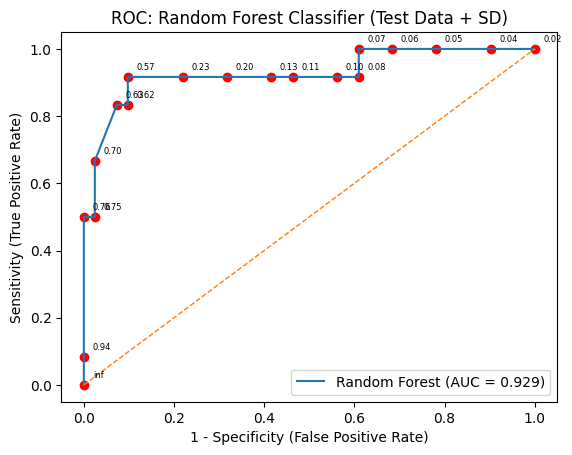

In [ ]:
# ROC pro klasifikátor trénovaný na train datech
y_score_clf = clf.predict_proba(X_test)[:, 1] # type: ignore
fpr_clf, tpr_clf, thresholds = roc_curve(y_test, y_score_clf)
roc_auc_clf2 = auc(fpr_clf, tpr_clf)

plt.figure()
plt.plot(fpr_clf, tpr_clf, label=f"Random Forest (AUC = {roc_auc_clf2:.3f})")
plt.scatter(fpr_clf, tpr_clf, color="red")
for x, y, val in zip(fpr_clf, tpr_clf, thresholds):
    plt.text(x + 0.02, y + 0.02, f"{val:0.2f}", fontsize=6)
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.title("ROC: Random Forest Classifier (Test Data + SD)")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.legend(loc="lower right")
plt.show()

## Důležitost příznaků

V neposlední řadě náš může zajímat, jak důležité jsou vlastně jednotlivé příznaky.

Použité klasifikátory již na tuto otázku obsahují připravené metriky, které jsou zde extrahované a graficky zobrazené.

Jak je možné z grafu sledovat, nejdůležitější částí příznakového vektoru je celkový počet správně vybavených slov, po něm je pak druhý nejdůležitější věk.

Tento styl analýzy se může hodit v případě, kdy by získávání nějakého příznaku bylo náročné nebo drahé - pokud by příznak nebyl důležitý, bylo by možné jej vypustit, aniž by to příliš ovlivnilo výsledky klasifikace.

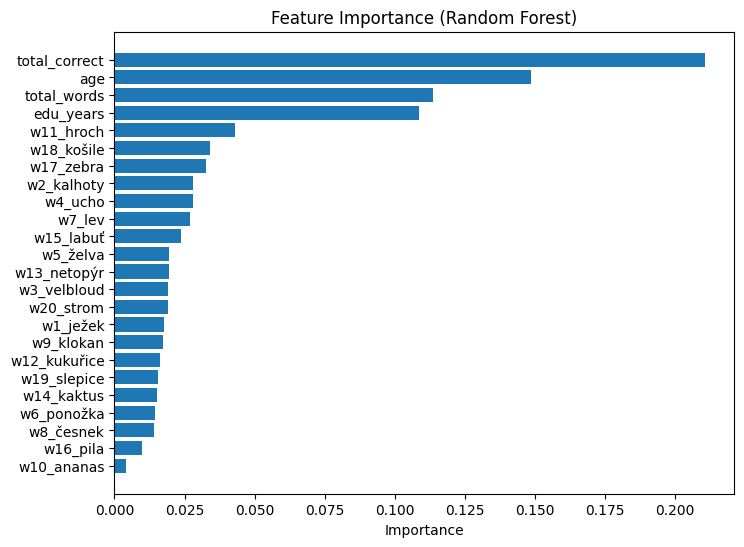

In [ ]:
# důležitost příznaků
importances = clf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()